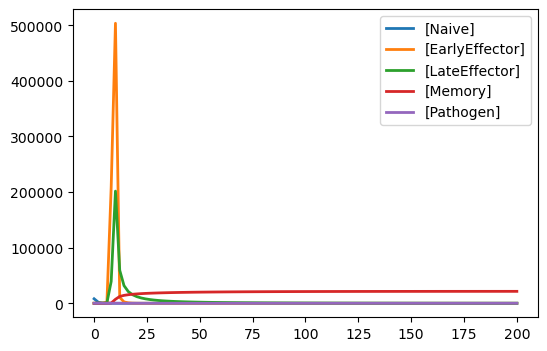

       time,      [Naive], [EarlyEffector], [LateEffector], [Memory],  [Pathogen]
 [[       0,         8090,               0,              0,        0,           1],
  [  2.0202,      1764.83,         124.041,             72,  1.17883,     1.34005],
  [  4.0404,      380.597,         280.297,        260.059,  8.19735,     2.00935],
  [ 6.06061,      79.8755,         1621.57,         927.65,  30.8709,     3.91904],
  [ 8.08081,      14.4918,          208907,        39402.2,  386.267,     20.9229],
  [  10.101,      1.10032,          503632,         201739,  7188.11,     35.4681],
  [ 12.1212,     0.222264,         10640.5,        59365.4,    12276,   0.0298918],
  [ 14.1414,    0.0498447,         2471.32,        31781.3,  14234.2,  0.00128149],
  [ 16.1616,    0.0111801,         774.577,        21071.4,  15410.1, 0.000193145],
  [ 18.1818,   0.00250772,         262.119,        15400.8,  16230.3, 5.15955e-05],
  [  20.202,  0.000562488,         90.8953,        11930.7,    16848, 1.90957e

In [1]:
# %cd /home/plent/Documenten/Gitlab/NeuralODEs/symplectic_adjoint
import tellurium as te
import time
import numpy as np
import matplotlib.pyplot as plt

model=te.loadSBMLModel("sbml_models/Crauste_CellSystems2017.xml")
a=time.time()




sol=model.simulate(0,200,100)
# b=time.time()
model.plot()

model.getFullStoichiometryMatrix()

sol



In [2]:
help(model.simulate)

Help on method simulate in module roadrunner.roadrunner:

simulate(start=None, end=None, points=None, selections=None, output_file=None, steps=None, times=None) method of tellurium.roadrunner.extended_roadrunner.ExtendedRoadRunner instance
    Simulate and optionally plot current SBML model. This is the one stop shopping method
    for simulation and plotting.

    simulate accepts up to five positional arguments.

    The first five (optional) arguments are treated as:

        1: Start Time, if this is a number.

        2: End Time, if this is a number.

        3: Number of points, if this is a number.

        4: List of Selections. A list of variables to include in the output, e.g. ``['time','A']`` for a model with species ``A``. More below.

        5: output file path. The file to which simulation results will be written. If this is specified and
        nonempty, simulation output will be written to output_file every Config::K_ROWS_PER_WRITE generated.
        Note that simula

In [13]:
import jaxlib.xla_extension
import sympy as sp
import jax.numpy as jnp
from sympy.utilities.lambdify import lambdify
import jax
import numpy as np
import equinox as eqx
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt
from functools import partial

import libsbml
from jax_kinetic_model import NeuralODE,create_fluxes_v
import os

from sbml_load import *
import tellurium as te




ModuleNotFoundError: No module named 'jax_kinetic_model'

import diffrax

In [4]:
# Load the model into a RoadRunner object

# Retrieve and print global parameters and their values



def get_parameters_from_tellurium(model):
    """retrieves parameters and initial conditions from tellurium"""
    global_parameters = model.getGlobalParameterIds()
    global_params_dict={}
    species_dict={}
    print("Global Parameters and Values:")
    for param in global_parameters:
        global_params_dict[param] = model[param]


    # Retrieve and print boundary species and their values
    boundary_species = model.getFloatingSpeciesIds()

    for species in boundary_species:
        species_dict[species] = model[species]
    
    return species_dict,global_params_dict

get_parameters_from_tellurium(model)

model.getFullStoichiometryMatrix(
    
)
    

Global Parameters and Values:


             reaction_1, reaction_2, reaction_3, reaction_4
species_1 [[          1,         -1,          0,          0],
species_2  [          0,          0,          1,         -1],
species_3  [          0,          0,          0,          0]]

             reaction_1, reaction_2, reaction_3, reaction_4
species_1 [[          1,         -1,          0,          0],
species_2  [          0,          0,          1,         -1],
species_3  [          0,          0,          0,          0]]

my_dict1 = {'key1': 'value1'}
my_dict2 = {'key2': 'value2'}
my_dict1.update(my_dict2)
print(my_dict1)  # Output:

In [5]:
my_dict1 = {'key1': 'value1'}
my_dict2 = {'key2': 'value2'}
my_dict1.update(my_dict2)
print(my_dict1)  # Output:

{'key1': 'value1', 'key2': 'value2'}


In [28]:
import diffrax




help(diffrax.Kvaerno5())

Help on Kvaerno5 in module diffrax._solver.kvaerno5 object:

class Kvaerno5(diffrax._solver.runge_kutta.AbstractESDIRK)
 |  Kvaerno5(scan_kind: Optional[Literal['lax', 'checkpointed', 'bounded']] = None, root_finder: optimistix._root_find.AbstractRootFinder = VeryChord(
 |    rtol=<tolerance taken from `diffeqsolve(..., stepsize_controller=...)` argument>,
 |    atol=<tolerance taken from `diffeqsolve(..., stepsize_controller=...)` argument>,
 |    norm=<tolerance taken from `diffeqsolve(..., stepsize_controller=...)` argument>,
 |    kappa=0.01,
 |    linear_solver=AutoLinearSolver(well_posed=None)
 |  ), root_find_max_steps: int = 10) -> None
 |
 |  Kvaerno's 5/4 method.
 |
 |  A-L stable stiffly accurate 5th order ESDIRK method. Has an embedded 4th order
 |  method for adaptive step sizing. Uses 7 stages with FSAL. Uses 3rd order Hermite
 |  interpolation for dense/ts output.
 |
 |  When solving an ODE over the interval $[t_0, t_1]$, note that this method will make
 |  some evaluati